In [1]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np
import torch.nn as nn
import torchvision.models as models
import matplotlib.pyplot as plt
import shap
import torchvision.transforms as transforms


In [2]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name)
        label = self.dataframe.iloc[idx, 1]
        
        if self.transform:
            image = self.transform(image)

        return image, label

In [3]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2),
    transforms.RandomChoice([
        transforms.RandomRotation(30),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.RandomAffine(degrees=0, scale=(0.8, 1.2)),
    ]),
    transforms.RandomChoice([
        transforms.RandomVerticalFlip(),
        transforms.RandomPerspective(distortion_scale=0.5),
    ]),
    transforms.RandomGrayscale(p=0.2),  
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.1),  
    transforms.RandomApply([transforms.RandomRotation(90)], p=0.1),  
    transforms.RandomApply([transforms.RandomCrop(size=(224, 224), padding=32)], p=0.1), 
    transforms.RandomApply([transforms.RandomAffine(degrees=0, shear=(0, 10))], p=0.1),  
    transforms.RandomApply([transforms.RandomPosterize(bits=4)], p=0.1),  
    transforms.RandomApply([transforms.RandomSolarize(threshold=128)], p=0.1),  
    transforms.RandomApply([transforms.RandomInvert()], p=0.1),  
    transforms.RandomApply([transforms.RandomAutocontrast()], p=0.1),  
    transforms.RandomApply([transforms.RandomEqualize()], p=0.1),  
    transforms.RandomApply([transforms.RandomResizedCrop(224, scale=(0.5, 1.0))], p=0.1), 
    transforms.RandomApply([transforms.RandomRotation(180)], p=0.1),  
    transforms.RandomApply([transforms.RandomAffine(degrees=0, translate=(0.2, 0.2))], p=0.1), 
    transforms.RandomApply([transforms.RandomAffine(degrees=0, scale=(0.8, 1.2))], p=0.1),  
    transforms.RandomApply([transforms.RandomPerspective(distortion_scale=0.5)], p=0.1), 
    transforms.RandomApply([transforms.RandomResizedCrop(224, scale=(0.8, 1.2))], p=0.1),  
    transforms.RandomApply([transforms.RandomAffine(degrees=0, shear=(0, 10))], p=0.1),  
    transforms.RandomApply([transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))], p=0.1),  
    transforms.RandomApply([transforms.RandomAffine(degrees=0, scale=(0.8, 1.2))], p=0.1),  
    transforms.RandomApply([transforms.RandomPerspective(distortion_scale=0.5)], p=0.1),  
    transforms.RandomApply([transforms.RandomResizedCrop(224, scale=(0.8, 1.2))], p=0.1), 
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])


In [4]:
# Load CSV
csv_path = 'er_status_all_data.csv'
dataframe = pd.read_csv(csv_path)

In [5]:
# Splitting datasets (70% training, 10% validation, 20% test)
train_val_patients, test_patients = train_test_split(dataframe['sample'].unique(), test_size=0.2, random_state=42)
train_patients, val_patients = train_test_split(train_val_patients, test_size=0.125, random_state=42)

train_data = dataframe[dataframe['sample'].isin(train_patients)]
val_data = dataframe[dataframe['sample'].isin(val_patients)]
test_data = dataframe[dataframe['sample'].isin(test_patients)]

In [6]:
# Initialize datasets
train_dataset = CustomDataset(train_data, root_dir='/Users/VanKhai/Desktop/TCGA_BRCA_Histology/', transform=train_transform)
val_dataset = CustomDataset(val_data, root_dir='/Users/VanKhai/Desktop/TCGA_BRCA_Histology/', transform=test_transform)
test_dataset = CustomDataset(test_data, root_dir='/Users/VanKhai/Desktop/TCGA_BRCA_Histology/', transform=test_transform)
# Initialize dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False) 
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False) 

In [7]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Dropout(0.3), 
            nn.Linear(num_ftrs, 1)
        )

    def forward(self, x):
        x = self.resnet(x)
        return x

In [8]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
# Initialize model
model = CustomCNN().to(device)

/Users/VanKhai/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/VanKhai/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
weight_decay = 0.01  
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay)

In [11]:
num_epochs = 5

In [12]:
# Initialize metrics history
train_loss_history = []
test_loss_history = []
train_accuracy_history = []
test_accuracy_history = []

# Training and evaluation loop
for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels_tuple in train_dataloader:
        labels = torch.tensor([1 if label == 'Positive' else 0 for label in labels_tuple]).float().to(device)
        inputs = images.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        predictions = torch.sigmoid(outputs).round()
        correct_train += (predictions.squeeze() == labels).sum().item()
        total_train += labels.size(0)
    
    train_loss = running_loss / len(train_dataset)
    train_accuracy = correct_train / total_train
    train_loss_history.append(train_loss)
    train_accuracy_history.append(train_accuracy)
    
    # Evaluation
    model.eval()
    running_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for inputs, labels_tuple in test_dataloader:
            labels = torch.tensor([1 if label == 'Positive' else 0 for label in labels_tuple]).float().to(device)
            inputs = inputs.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            running_loss += loss.item() * inputs.size(0)
            predictions = torch.sigmoid(outputs).round()
            correct_test += (predictions.squeeze() == labels).sum().item()
            total_test += labels.size(0)
    
    test_loss = running_loss / len(test_dataset)
    test_accuracy = correct_test / total_test
    test_loss_history.append(test_loss)
    test_accuracy_history.append(test_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


Epoch 1/5, Train Loss: 0.6408, Train Accuracy: 0.6493, Test Loss: 0.7839, Test Accuracy: 0.3068
Epoch 2/5, Train Loss: 0.6283, Train Accuracy: 0.6566, Test Loss: 0.8766, Test Accuracy: 0.1520
Epoch 3/5, Train Loss: 0.6350, Train Accuracy: 0.6533, Test Loss: 0.8675, Test Accuracy: 0.1614
Epoch 4/5, Train Loss: 0.6220, Train Accuracy: 0.6610, Test Loss: 0.6387, Test Accuracy: 0.6693
Epoch 5/5, Train Loss: 0.6144, Train Accuracy: 0.6678, Test Loss: 0.6279, Test Accuracy: 0.6035


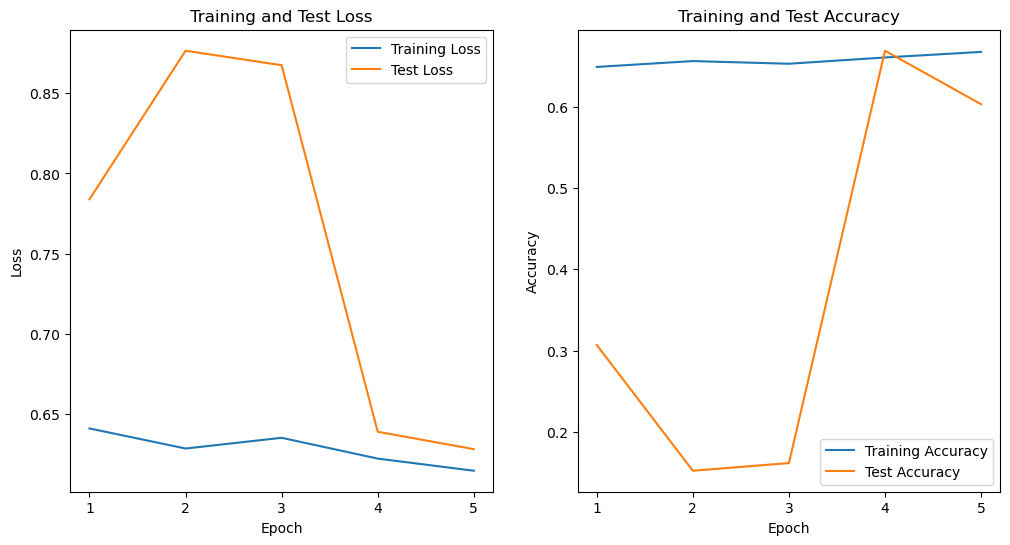

In [49]:
# Adjust the figure size and create subplots
plt.figure(figsize=(12, 6))

# Plot training and test loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_loss_history, label='Training Loss')
plt.plot(range(1, num_epochs+1), test_loss_history, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.xticks(range(1, num_epochs+1))  

# Plot training and test accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracy_history, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), test_accuracy_history, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()
plt.xticks(range(1, num_epochs+1))  

plt.show()


In [32]:
# Check the shape of an image batch
test_images, test_labels = next(iter(test_dataloader))
print(test_images.shape) 


torch.Size([64, 3, 224, 224])


  0%|          | 0/298 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.35s/it]                            
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


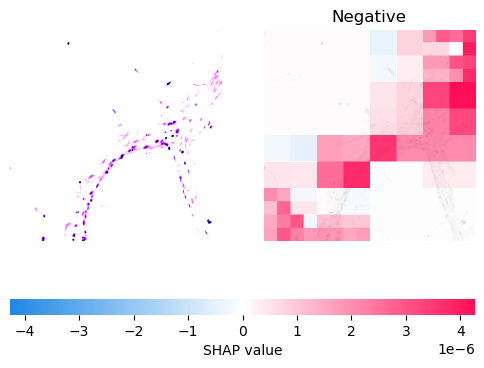

In [34]:
# Assuming that preprocessing is required, define a preprocessing function
def preprocess_input(x):
    # Normalize according to your model's requirement
    transform = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    return transform(x)

def f(x):
    # Convert numpy array to tensor
    x = torch.tensor(x, dtype=torch.float32)  # Ensure data type compatibility
    x = x.permute(0, 3, 1, 2)  # Change from NHWC to NCHW if necessary
    
    # Apply preprocessing
    x = preprocess_input(x)
    
    # Move the tensor to the correct device
    x = x.to(device)
    
    with torch.no_grad():
        return model(x).cpu().numpy()

# Create the SHAP explainer with the correct prediction function
masker = shap.maskers.Image("inpaint_telea", shape=(224, 224, 3))
explainer = shap.Explainer(f, masker, output_names=["Negative", "Positive"])

# Select a subset of data for explanation, ensuring it's in the right format
test_images, test_labels = next(iter(test_dataloader))
test_images_np = test_images.numpy().transpose((0, 2, 3, 1))  # Convert from NCHW to NHWC

# Compute SHAP values
shap_values = explainer(test_images_np[:1], max_evals=300)  # Adjust as needed

# Visualize the SHAP values
shap.image_plot(shap_values)


  0%|          | 0/298 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


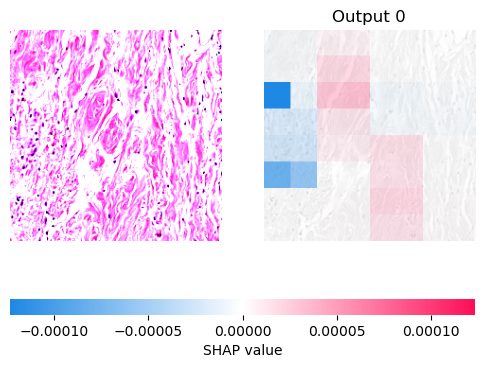

In [51]:
# Assuming that preprocessing is required, define a preprocessing function
def preprocess_input(x):
    # Normalize according to your model's requirement
    transform = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    return transform(x)

def f(x):
    # Convert numpy array to tensor
    x = torch.tensor(x, dtype=torch.float32)  # Ensure data type compatibility
    x = x.permute(0, 3, 1, 2)  # Change from NHWC to NCHW if necessary
    
    # Apply preprocessing
    x = preprocess_input(x)
    
    # Move the tensor to the correct device
    x = x.to(device)
    
    with torch.no_grad():
        return model(x).cpu().numpy()

# Create the SHAP explainer with the correct prediction function
masker = shap.maskers.Image("inpaint_telea", shape=(224, 224, 3))
explainer = shap.Explainer(f, masker)

# Select a subset of data for explanation, ensuring it's in the right format
test_images, test_labels = next(iter(test_dataloader))
test_images_np = test_images.numpy().transpose((0, 2, 3, 1))  # Convert from NCHW to NHWC

# Compute SHAP values
shap_values = explainer(test_images_np[25:26], max_evals=300)  # Adjust as needed

# Visualize the SHAP values
shap.image_plot(shap_values)


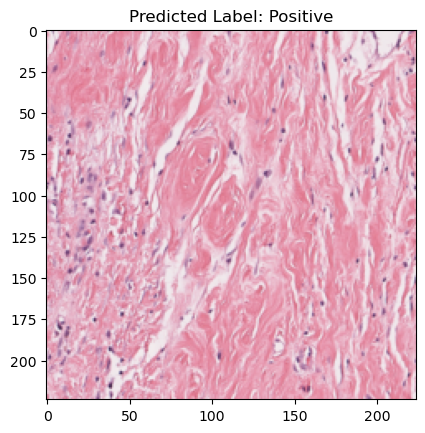

In [62]:
# Get a batch of test images and labels
test_images, test_labels = next(iter(test_dataloader))
test_image = test_images[25].unsqueeze(0).to(device)  # Get the first image in the batch and add batch dimension

# Make prediction
model.eval()
with torch.no_grad():
    output = model(test_image)
    predicted_label = torch.sigmoid(output).round().item()

# Convert the tensor to a displayable image
test_image = test_image.squeeze(0).cpu()  # Remove batch dimension and move to cpu
test_image = test_image.numpy().transpose((1, 2, 0))  # Rearrange dimensions for displaying
test_image = test_image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Denormalize
test_image = np.clip(test_image, 0, 1)  # Clip values to be between 0 and 1

# Plotting
plt.imshow(test_image)
plt.title(f'Predicted Label: {"Positive" if predicted_label == 1 else "Negative"}')
plt.show()


In [70]:
def f(x):
    # Convert numpy array to tensor
    x = torch.tensor(x, dtype=torch.float32)  # Ensure data type compatibility
    x = x.permute(0, 3, 1, 2)  # Change from NHWC to NCHW if necessary
    
    # Apply preprocessing
    x = preprocess_input(x)
    
    # Move the tensor to the correct device
    x = x.to(device)
    
    with torch.no_grad():
        outputs = model(x)
        probabilities = torch.sigmoid(outputs).cpu().numpy()
        return probabilities  # Return probabilities for SHAP

# Create the SHAP explainer with the correct prediction function
masker = shap.maskers.Image("inpaint_telea", shape=(224, 224, 3))
explainer = shap.Explainer(f, masker)

# Select a subset of data for explanation
test_images, test_labels = next(iter(test_dataloader))
test_images_np = test_images.numpy().transpose((0, 2, 3, 1))  # Convert from NCHW to NHWC

# Compute SHAP values
shap_values = explainer(test_images_np[25:26], max_evals=300)  # Adjust as needed

# Compute predictions separately
predictions = f(test_images_np[25:26]) > 0.5  # Use threshold of 0.5 for binary classification

# Log output predictions
for idx, pred in enumerate(predictions):
    print(f"Sample {idx + 25}: {'Positive' if pred else 'Negative'}")

# Visualize the SHAP values
shap.image_plot(shap_values)


ValueError: Input dimension should be at least 3

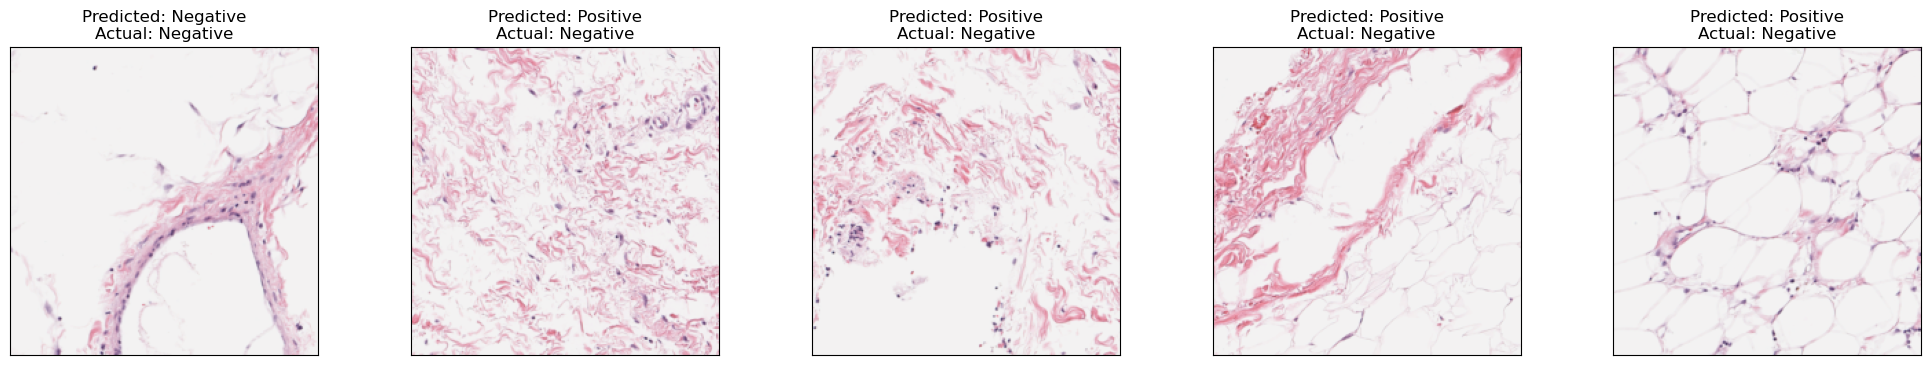

In [65]:
def show_test_predictions(dataloader, model, device, num_images=5):
    model.eval()  # Set the model to evaluation mode
    images, labels = next(iter(dataloader))  # Correctly use next() to fetch the next batch

    # Move the images to the device
    images = images.to(device)
    # No need to move labels to the device if they are only used for printing or CPU-based processing

    with torch.no_grad():
        outputs = model(images)
        probabilities = torch.sigmoid(outputs)  # Apply sigmoid to get probabilities
        predicted_labels = (probabilities > 0.5).long().squeeze()  # Convert probabilities to binary labels

    # Convert images from PyTorch tensor to NumPy array and normalize
    images = images.cpu().numpy()

    # Set up plot
    fig = plt.figure(figsize=(25, 4))

    # Display images
    for idx in range(min(num_images, images.shape[0])):  # Ensure we do not go out of bounds
        ax = fig.add_subplot(1, num_images, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx])
        # Ensure correct display of actual labels based on how labels are stored (e.g., if they are tensors or lists)
        actual_label = 'Positive' if labels[idx] == 'Positive' else 'Negative'
        predicted_label = 'Positive' if predicted_labels[idx].item() == 1 else 'Negative'
        ax.set_title(f"Predicted: {predicted_label}\nActual: {actual_label}")

def matplotlib_imshow(img):
    img = img.transpose((1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  # Unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)

# Usage example:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomCNN().to(device)
show_test_predictions(test_dataloader, model, device, num_images=5)
